# Data Load

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! unzip /content/drive/MyDrive/Datasets_for_Projects.zip

Streaming output truncated to the last 5000 lines.
  inflating: places/test_256/Places365_test_00323501.jpg  
  inflating: places/test_256/Places365_test_00323502.jpg  
  inflating: places/test_256/Places365_test_00323503.jpg  
  inflating: places/test_256/Places365_test_00323504.jpg  
  inflating: places/test_256/Places365_test_00323505.jpg  
  inflating: places/test_256/Places365_test_00323506.jpg  
  inflating: places/test_256/Places365_test_00323507.jpg  
  inflating: places/test_256/Places365_test_00323508.jpg  
  inflating: places/test_256/Places365_test_00323509.jpg  
  inflating: places/test_256/Places365_test_00323510.jpg  
  inflating: places/test_256/Places365_test_00323511.jpg  
  inflating: places/test_256/Places365_test_00323512.jpg  
  inflating: places/test_256/Places365_test_00323513.jpg  
  inflating: places/test_256/Places365_test_00323514.jpg  
  inflating: places/test_256/Places365_test_00323515.jpg  
  inflating: places/test_256/Places365_test_00323516.jpg  
  inf

In [4]:
!pip install segmentation-models-pytorch --quiet
!pip install pytorch-msssim --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 40.1 MB/s eta 0:00:00


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, ConcatDataset, Dataset, Subset
import random
import torchvision
from torchvision import transforms, datasets
from torchvision.models import vgg11
import segmentation_models_pytorch as smp
import os
import csv
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
from pytorch_msssim import SSIM

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# Combine Datasets

In [7]:
def split_data(data, train_ratio=0.8, valid_ratio=0.1):

    random.seed(1773)

    total_data_len = len(data)
    indices = list(range(total_data_len))
    random.shuffle(indices)

    train_size = int(train_ratio * total_data_len)
    valid_size = int(valid_ratio * total_data_len)
    test_size  = total_data_len - train_size - valid_size

    train_indices = indices[:train_size]
    valid_indices = indices[train_size:train_size + valid_size]
    test_indices  = indices[train_size + valid_size:]

    train_dataset = Subset(data, train_indices)
    valid_dataset = Subset(data, valid_indices)
    test_dataset  = Subset(data, test_indices)

    return train_dataset, valid_dataset, test_dataset

In [8]:
class Custom_Dataset(Dataset):
    def __init__(self, dataset, transform=None, mask_prob=0.2, patch_size=16):
        self.dataset = dataset
        self.transform = transform
        self.mask_prob = mask_prob
        self.patch_size = patch_size

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image, _ = self.dataset[index]

        if self.transform:
            image = self.transform(image)

        # masked version
        masked_image, mask = self.create_mask(image)

        return image, masked_image, mask

    def create_mask(self, image):
        masked_image = image.clone()
        random.seed(1773)
        _, height, width = image.shape

        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size

        mask = torch.zeros((num_patches_h * num_patches_w), dtype=torch.bool)

        idx = 0
        for i in range(num_patches_h):
            for j in range(num_patches_w):
                if random.random() < self.mask_prob:
                    x_min, x_max = i * self.patch_size, (i+1) * self.patch_size
                    y_min, y_max = j * self.patch_size, (j+1) * self.patch_size

                    masked_image[:, x_min:x_max, y_min:y_max] = 0
                    mask[idx] = True
                idx += 1

        return masked_image, mask

In [9]:
transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset1 = datasets.ImageFolder(root="celeba/")
dataset2 = datasets.ImageFolder(root="places/")

custom_data1 = Custom_Dataset(dataset1, transform=transform_image)
custom_data2 = Custom_Dataset(dataset2, transform=transform_image)

# combining
combined_dataset = ConcatDataset([custom_data1, custom_data2])
random.seed(1773)
train_dataset, valid_dataset, test_dataset = split_data(combined_dataset)

# DataLoaders
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

print("Train dataset size:", len(train_dataset))
print("Valid dataset size:", len(valid_dataset))
print("Test dataset size: ", len(test_dataset))

Train dataset size: 424879
Valid dataset size: 53109
Test dataset size:  53111


# Example of Mask

In [10]:
def unnormalize_and_convert(image):
    image = image.permute(1, 2, 0).cpu().detach().numpy()
    image = (image * 0.5) + 0.5
    image = np.clip(image, 0, 1)
    return image

# Plot Sample Image

In [14]:
def plot_sample_image(original_image, masked_image, inpainted_image, expanded_mask,
                      save_path=None, image_name=None):
    clear_output(wait=True)
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # original
    ax[0].imshow(unnormalize_and_convert(original_image))
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    # masked
    ax[1].imshow(unnormalize_and_convert(masked_image))
    ax[1].set_title("Masked Image")
    ax[1].axis('off')

    # inpainted
    inpainted_image = inpainted_image * expanded_mask + masked_image
    ax[2].imshow(unnormalize_and_convert(inpainted_image))
    ax[2].set_title("Inpainted Image")
    ax[2].axis('off')

    plt.tight_layout()
    if save_path and image_name:
        os.makedirs(save_path, exist_ok=True)
        file_path = os.path.join(save_path, image_name)
        plt.savefig(file_path)
        print("Saved:", file_path)

    plt.show()

# Encoder-Decoder Network

In [15]:
class UNetInpainting(nn.Module):
    def __init__(self, encoder_name="resnet34", pretrained=True):
        super(UNetInpainting, self).__init__()
        # weights as ImageNet weights
        encoder_weights = "imagenet" if pretrained else None

        # encoder as resnet34
        # pretrained on ImageNet
        # decoder handled internally by the smp.Unet class
        self.unet = smp.Unet(
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            in_channels=3,
            classes=3
        )

    def forward(self, x, mask):
        out = self.unet(x)
        return out

# Performance Metrics

In [16]:
def psnr(output, target, mask):
    # focused on masked areas
    output = output * mask
    target = target * mask

    mse = torch.mean((output - target)**2, dim=(1,2,3))
    mse = torch.where(mse == 0, torch.tensor(1e-10, device=mse.device), mse)
    psnr_val = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return psnr_val.mean().item()

def pixel_accuracy(output, target, mask):
    output = output * mask
    target = target * mask
    correct = (torch.abs(output - target) < 1).float()
    denom = mask.sum(dim=(1,2,3))
    denom = torch.where(denom==0, torch.tensor(1.0, device=denom.device), denom)
    acc_per_image = correct.sum(dim=(1,2,3)) / denom
    return acc_per_image.mean().item()

def mse(output, target, mask):
    # focused on masked region
    masked_output = output * mask
    masked_target = target * mask
    mse_val = nn.functional.mse_loss(masked_output, masked_target, reduction='mean')
    return mse_val

# Loss

In [17]:
class LightweightPerceptualLoss(nn.Module):
    def __init__(self):
        super(LightweightPerceptualLoss, self).__init__()
        vgg = vgg11(pretrained=True).features[:8]
        self.feature_extractor = nn.Sequential(*list(vgg))
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

    def forward(self, output, target):
        out_feats = self.feature_extractor(output)
        tgt_feats = self.feature_extractor(target)
        loss = F.mse_loss(out_feats, tgt_feats)
        return loss

class CombinedLoss(nn.Module):
    def __init__(self, perceptual_weight=0.3, ssim_weight=0.7):
        super(CombinedLoss, self).__init__()
        self.perceptual_loss = LightweightPerceptualLoss()
        self.ssim_loss = SSIM(data_range=1, size_average=True, channel=3)
        self.perceptual_weight = perceptual_weight
        self.ssim_weight       = ssim_weight

    def forward(self, output, target, expanded_mask):
        # focused on masked areas
        masked_output = output * expanded_mask
        masked_target = target * expanded_mask

        ssim_loss_val = 1.0 - self.ssim_loss(masked_output, masked_target)
        perceptual_loss_val = self.perceptual_loss(output, target)
        total_loss = (self.ssim_weight * ssim_loss_val +
                      self.perceptual_weight * perceptual_loss_val)
        return total_loss

# Train Model

In [38]:
def save_checkpoint(epoch, model, optimizer, scaler, best_valid_loss, path="checkpoint.pth"):
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scaler_state_dict": scaler.state_dict(),
        "best_valid_loss": best_valid_loss
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved: {path}")

In [39]:
def train_model(model, optimizer, scaler, start_epoch, best_valid_loss,
                train_loader, valid_loader, num_epochs=1, device="cuda"):
    patience = 3
    patience_counter = 0

    criterion = CombinedLoss().to(device)
    model.to(device)
    model.train()

    for epoch in range(start_epoch, start_epoch + num_epochs):
        train_PSNR = 0.0
        train_accuracy = 0.0
        train_mse = 0.0
        plot_counter = 1
        idx_plot = 0
        total_train_loss = 0.0

        # Train
        for images, masked_images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}, Train"):
            images, masked_images, masks = images.to(device), masked_images.to(device), masks.to(device)

            expanded_mask = masks.view(masks.size(0), 14, 14)
            expanded_mask = expanded_mask.repeat_interleave(16, dim=1).repeat_interleave(16, dim=2)
            expanded_mask = expanded_mask.unsqueeze(1).float()

            with torch.amp.autocast(device_type='cuda', enabled=(device=='cuda')):
                outputs = model(masked_images, masks)
                loss = criterion(outputs, images, expanded_mask)

            # Metrics
            batch_psnr = psnr(outputs, images, expanded_mask)
            batch_acc  = pixel_accuracy(outputs, images, expanded_mask)
            batch_mse  = mse(outputs, images, expanded_mask).item()

            # Summing up for averaging
            train_PSNR += batch_psnr
            train_accuracy += batch_acc
            train_mse += batch_mse
            total_train_loss += loss.item()

            # Visualization
            plot_counter -= 1
            if plot_counter == 0:
                plot_counter = 1500
                idx_plot += 1
                plot_sample_image(images[0], masked_images[0], outputs[0], expanded_mask[0],
                                  save_path="UNet_Training_Images",
                                  image_name=f"Epoch_{epoch+1}_idx_{idx_plot}.png")

            # Backpropogation and update
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()

        # Avgs over the entire epoch
        avg_train_PSNR = train_PSNR / len(train_loader)
        avg_train_accuracy = train_accuracy / len(train_loader)
        avg_train_mse = train_mse / len(train_loader)
        avg_train_loss = total_train_loss / len(train_loader)

        print(f"[Epoch {epoch+1} - Training] "
              f"Loss: {avg_train_loss:.4f}, "
              f"MSE: {avg_train_mse:.4f}, "
              f"PSNR: {avg_train_PSNR:.4f}, "
              f"Accuracy: {avg_train_accuracy:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        val_PSNR = 0.0
        val_accuracy = 0.0
        val_mse = 0.0
        first_time = True

        with torch.no_grad():
            for images, masked_images, masks in tqdm(valid_loader, desc=f"Epoch {epoch+1}, Validation"):
                images, masked_images, masks = images.to(device), masked_images.to(device), masks.to(device)

                expanded_mask = masks.view(masks.size(0), 14, 14)
                expanded_mask = expanded_mask.repeat_interleave(16, dim=1).repeat_interleave(16, dim=2)
                expanded_mask = expanded_mask.unsqueeze(1).float()

                outputs = model(masked_images, masks)
                loss = criterion(outputs, images, expanded_mask)
                val_loss += loss.item()

                # Metrics
                batch_psnr = psnr(outputs, images, expanded_mask)
                val_PSNR += batch_psnr

                batch_acc = pixel_accuracy(outputs, images, expanded_mask)
                val_accuracy += batch_acc

                batch_mse = mse(outputs, images, expanded_mask).item()
                val_mse += batch_mse

                # Visualization
                if first_time:
                    first_time = False
                    plot_sample_image(images[0], masked_images[0], outputs[0], expanded_mask[0],
                                      save_path="UNet_Validation_Images",
                                      image_name=f"Epoch_{epoch+1}.png")

        avg_val_loss = val_loss / len(valid_loader)
        avg_val_PSNR = val_PSNR / len(valid_loader)
        avg_val_acc  = val_accuracy / len(valid_loader)
        avg_val_mse  = val_mse / len(valid_loader)

        print(f"[Epoch {epoch+1} - Validation] "
              f"Loss: {avg_val_loss:.4f}, "
              f"MSE: {avg_val_mse:.4f}, "
              f"PSNR: {avg_val_PSNR:.4f}, "
              f"Acc: {avg_val_acc:.4f}")

        # Early Stopping / Checkpoint
        if avg_val_loss < best_valid_loss:
            best_valid_loss = avg_val_loss
            patience_counter = 0
            save_checkpoint(epoch+1, model, optimizer, scaler, best_valid_loss, path="best_model.pth")
            print("Model improved and saved.")
        else:
            patience_counter += 1
            if patience_counter > patience:
                print("Early stopping.")
                break

        # Write to csv
        with open("training_metrics_unet.csv", "a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([epoch+1, avg_train_loss, avg_val_loss, avg_train_PSNR, avg_val_PSNR, avg_train_accuracy, avg_val_acc, avg_train_mse, avg_val_mse])

        model.train()

Saved: UNet_Validation_Images/Epoch_12.png


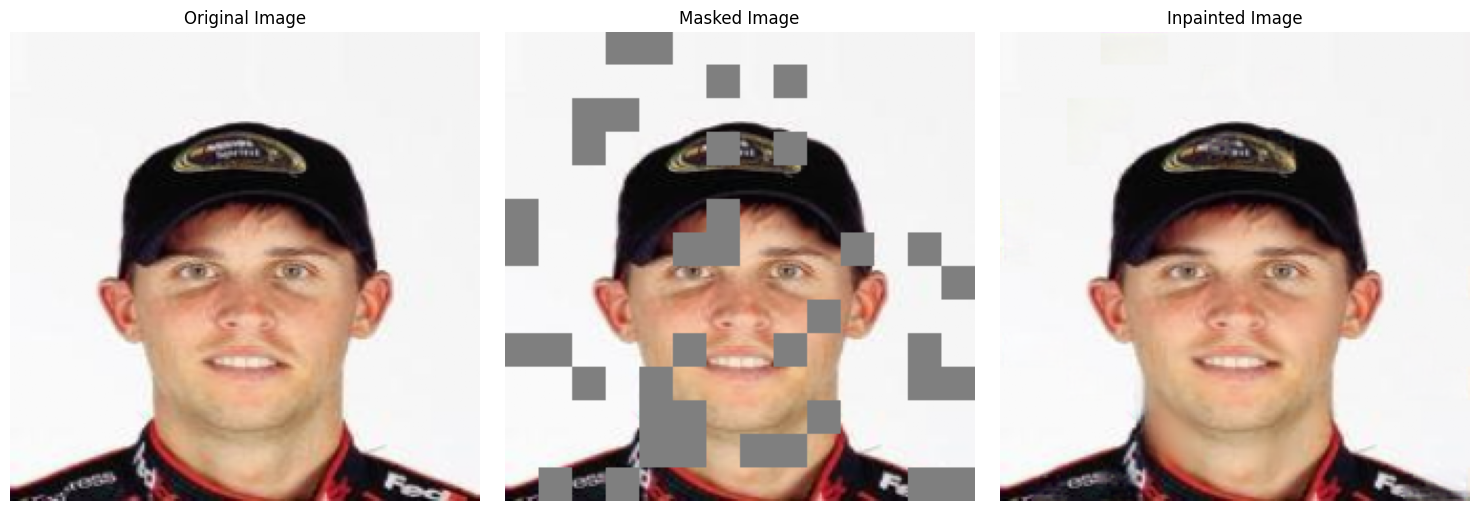

Epoch 12, Validation: 100%|██████████| 830/830 [03:42<00:00,  3.72it/s]


[Epoch 12 - Validation] Loss: 0.0707, MSE: 0.0048, PSNR: 24.4870, Acc: 15.4667
Checkpoint saved: best_model.pth
Model improved and saved.


In [40]:
model = UNetInpainting(encoder_name="resnet34", pretrained=True).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scaler = torch.amp.GradScaler(enabled=(device=="cuda"))

trained_before = 1 # make 1 if you want it to continue from a checkpoint

if trained_before == 0:
    train_model(model, optimizer, scaler,
                start_epoch=0,
                best_valid_loss=float('inf'),
                train_loader=train_loader,
                valid_loader=valid_loader,
                num_epochs=10,
                device=device)
elif trained_before == 1:
    checkpoint = torch.load("best_model.pth", map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    scaler.load_state_dict(checkpoint["scaler_state_dict"])
    start_epoch = checkpoint["epoch"]
    best_valid_loss = float(checkpoint["best_valid_loss"])

    train_model(model, optimizer, scaler,
                start_epoch=start_epoch,
                best_valid_loss=best_valid_loss,
                train_loader=train_loader,
                valid_loader=valid_loader,
                num_epochs=1,
                device=device)
else:
    print("No training performed")

# Load Best Model

Saved: UNet_Final_Train_Images/Train_1.png


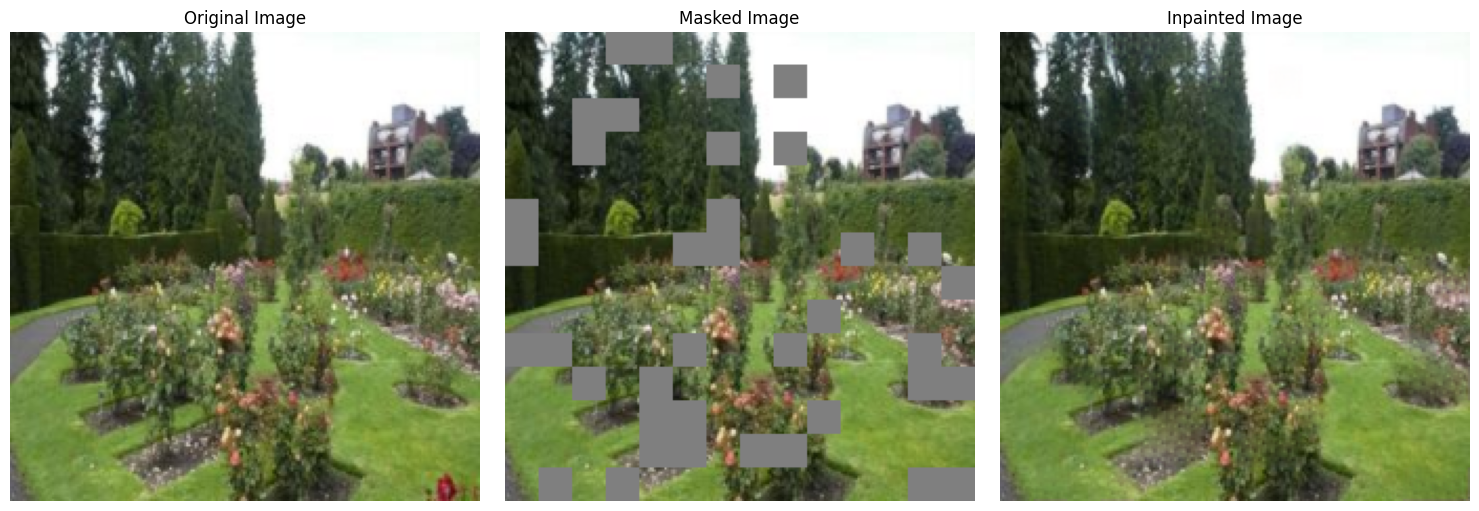

In [48]:
model.load_state_dict(torch.load("best_model.pth", map_location=device)["model_state_dict"])
model.eval()

with torch.no_grad():
    for idx, (images, masked_images, masks) in enumerate(train_loader):
        images, masked_images, masks = images.to(device), masked_images.to(device), masks.to(device)

        expanded_mask = masks.view(masks.size(0),14,14)
        expanded_mask = expanded_mask.repeat_interleave(16, dim=1).repeat_interleave(16, dim=2)
        expanded_mask = expanded_mask.unsqueeze(1).float()

        outputs = model(masked_images, masks)

        # Display
        if idx < 2:
            plot_sample_image(images[0], masked_images[0], outputs[0], expanded_mask[0],
                              save_path="UNet_Final_Train_Images",
                              image_name=f"Train_{idx}.png")
        else:
            break

# Evaluate

Saved: UNet_Test_Images/Test_640.png


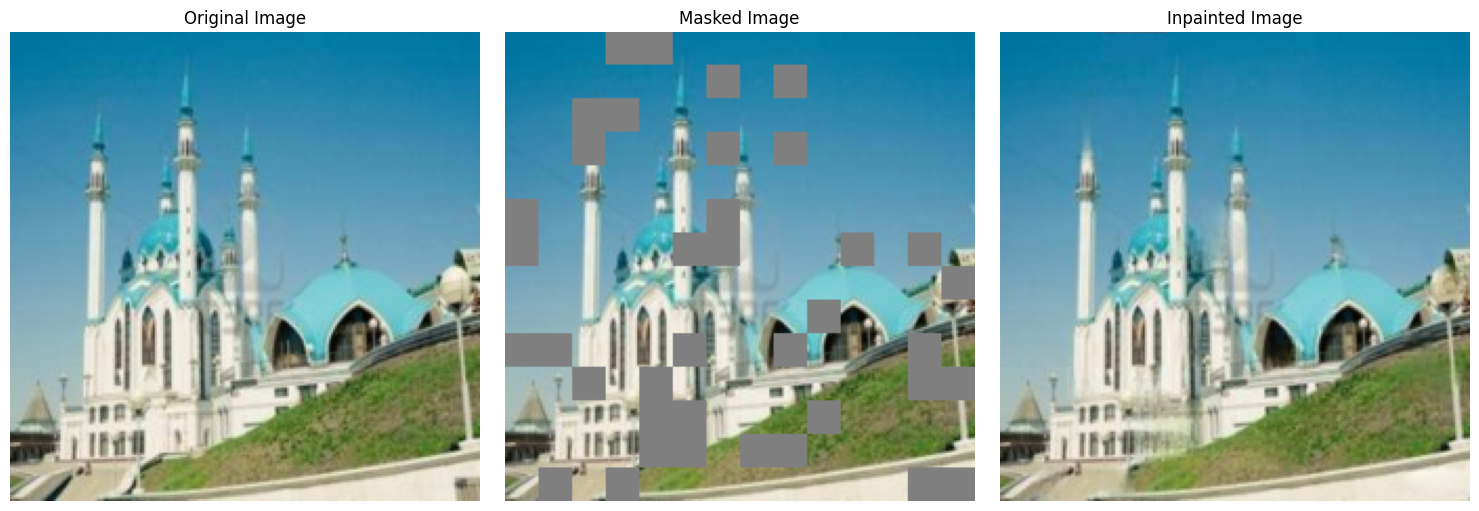

Test Results:
test_loss: 0.0667
test_PSNR: 24.4958
test_accuracy: 15.4668
test_mse: 0.0048


In [42]:
def evaluate(model, dataloader, device="cuda", sample_size=5):
    model.eval()
    ssim_fn = SSIM(data_range=1, size_average=True, channel=3)

    test_loss = 0.0
    test_PSNR = 0.0
    test_accuracy = 0.0
    test_mse = 0.0

    # random batch to visualize
    random_indices = random.sample(range(len(dataloader)), min(sample_size, len(dataloader)))

    with torch.no_grad():
        for idx, (images, masked_images, masks) in enumerate(dataloader):
            images, masked_images, masks = images.to(device), masked_images.to(device), masks.to(device)

            expanded_mask = masks.view(masks.size(0),14,14)
            expanded_mask = expanded_mask.repeat_interleave(16, dim=1).repeat_interleave(16, dim=2)
            expanded_mask = expanded_mask.unsqueeze(1).float()

            outputs = model(masked_images, masks)

            # SSIM
            ssim_val = ssim_fn(outputs * expanded_mask, images * expanded_mask)
            batch_loss = 1 - ssim_val
            test_loss += batch_loss.item()

            # PSNR and pixel acc
            batch_psnr = psnr(outputs, images, expanded_mask)
            batch_acc  = pixel_accuracy(outputs, images, expanded_mask)
            test_PSNR += batch_psnr
            test_accuracy += batch_acc

            # MSE
            batch_mse = mse(outputs, images, expanded_mask)
            test_mse += batch_mse.item()

            # Visualize some
            if idx in random_indices:
                plot_sample_image(
                    images[0],
                    masked_images[0],
                    outputs[0],
                    expanded_mask[0],
                    save_path="UNet_Test_Images",
                    image_name=f"Test_{idx}.png"
                )

    avg_test_loss = test_loss / len(dataloader)
    avg_test_PSNR = test_PSNR / len(dataloader)
    avg_test_acc  = test_accuracy / len(dataloader)
    avg_test_mse  = test_mse / len(dataloader)

    return {
        "test_loss": avg_test_loss,
        "test_PSNR": avg_test_PSNR,
        "test_accuracy": avg_test_acc,
        "test_mse": avg_test_mse
    }

results = evaluate(model, test_loader, device=device, sample_size=5)
print("Test Results:")
for key, val in results.items():
    print(f"{key}: {val:.4f}")

# Plot Loss Curves

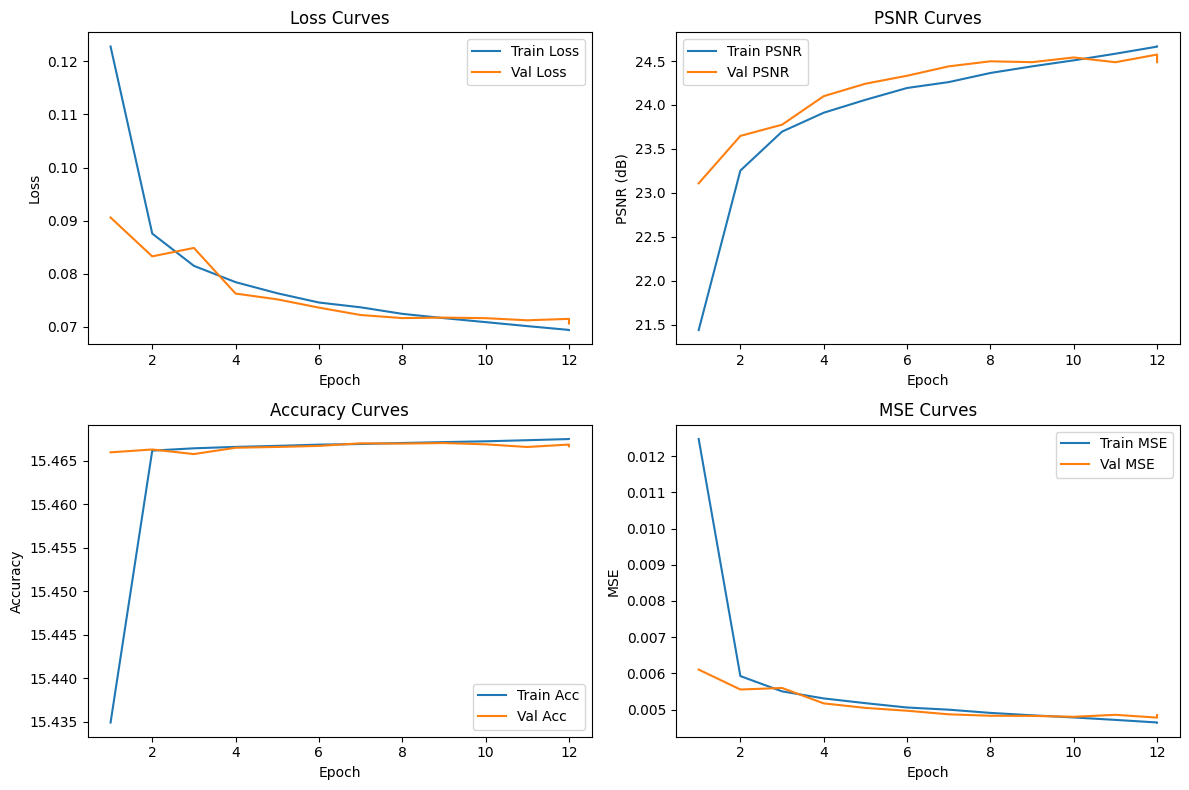

In [43]:
def plot_losses(csv_path="training_metrics_unet.csv"):
    if not os.path.exists(csv_path):
        print(f"No CSV file found at {csv_path}")
        return

    epochs = []
    train_loss, val_loss = [], []
    train_psnr, val_psnr = [], []
    train_acc, val_acc = [], []
    train_mse, val_mse = [], []

    with open(csv_path, "r") as f:
        reader = csv.reader(f)
        for row_idx, row in enumerate(reader):
            if row_idx == 0 and ("Epoch" in row[0]):
                continue

            ep, trl, vll, trp, vap, tra, vaa, trm, vam = row
            epochs.append(int(ep))
            train_loss.append(float(trl))
            val_loss.append(float(vll))
            train_psnr.append(float(trp))
            val_psnr.append(float(vap))
            train_acc.append(float(tra))
            val_acc.append(float(vaa))
            train_mse.append(float(trm))
            val_mse.append(float(vam))

    plt.figure(figsize=(12, 8))

    # Loss Plot
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curves")
    plt.legend()

    # PSNR Plot
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_psnr, label="Train PSNR")
    plt.plot(epochs, val_psnr, label="Val PSNR")
    plt.xlabel("Epoch")
    plt.ylabel("PSNR (dB)")
    plt.title("PSNR Curves")
    plt.legend()

    # Accuracy Plot
    plt.subplot(2, 2, 3)
    plt.plot(epochs, train_acc, label="Train Acc")
    plt.plot(epochs, val_acc, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curves")
    plt.legend()

    # MSE Plot
    plt.subplot(2, 2, 4)
    plt.plot(epochs, train_mse, label="Train MSE")
    plt.plot(epochs, val_mse, label="Val MSE")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title("MSE Curves")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_losses("training_metrics_unet.csv")

# Testing With Own Data

In [24]:
! unzip /content/drive/MyDrive/DL_JPG.zip

Archive:  /content/drive/MyDrive/DL_JPG.zip
   creating: DL_JPG/
  inflating: DL_JPG/IMG_1059.jpeg    
  inflating: __MACOSX/DL_JPG/._IMG_1059.jpeg  
  inflating: DL_JPG/IMG_5489.jpeg    
  inflating: __MACOSX/DL_JPG/._IMG_5489.jpeg  
  inflating: DL_JPG/IMG_9853.jpeg    
  inflating: __MACOSX/DL_JPG/._IMG_9853.jpeg  
  inflating: DL_JPG/IMG_1219.jpeg    
  inflating: __MACOSX/DL_JPG/._IMG_1219.jpeg  
  inflating: DL_JPG/IMG_0776.jpeg    
  inflating: __MACOSX/DL_JPG/._IMG_0776.jpeg  
  inflating: DL_JPG/IMG_2024.jpeg    
  inflating: __MACOSX/DL_JPG/._IMG_2024.jpeg  
  inflating: DL_JPG/IMG_5535.jpeg    
  inflating: __MACOSX/DL_JPG/._IMG_5535.jpeg  
  inflating: DL_JPG/IMG_2004.jpeg    
  inflating: __MACOSX/DL_JPG/._IMG_2004.jpeg  
  inflating: DL_JPG/IMG_9023.jpeg    
  inflating: __MACOSX/DL_JPG/._IMG_9023.jpeg  
  inflating: DL_JPG/IMG_8331.jpeg    
  inflating: __MACOSX/DL_JPG/._IMG_8331.jpeg  
  inflating: DL_JPG/IMG_3316.jpeg    
  inflating: __MACOSX/DL_JPG/._IMG_3316.jpeg  


In [61]:
import os
from PIL import Image, ImageOps
import torch
from torch.utils.data import Dataset
import pandas as pd
import shutil

In [56]:
class SimpleImageDataset(Dataset):
    def __init__(self, root, valid_extensions=(".jpg", ".jpeg", ".png"), transform=None):
        super().__init__()
        self.root = root
        self.transform = transform
        self.image_paths = []

        for fname in os.listdir(root):
            if fname.lower().endswith(valid_extensions):
                self.image_paths.append(os.path.join(root, fname))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        image = ImageOps.exif_transpose(image)

        image = image.convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        label = 0
        return image, label

In [57]:
dataset_dl_jpg = SimpleImageDataset(root="DL_JPG")
custom_data_gathered = Custom_Dataset(
    dataset_dl_jpg,
    transform=transform_image
)

batch_size = 16
dl_jpg_loader = DataLoader(custom_data_gathered, batch_size=batch_size, shuffle=False)
print(f"Number of batches in DL_JPG loader: {len(dl_jpg_loader)}")

Number of batches in DL_JPG loader: 7


Saved: UNet_Custom_Collected_Images/Image_69.png


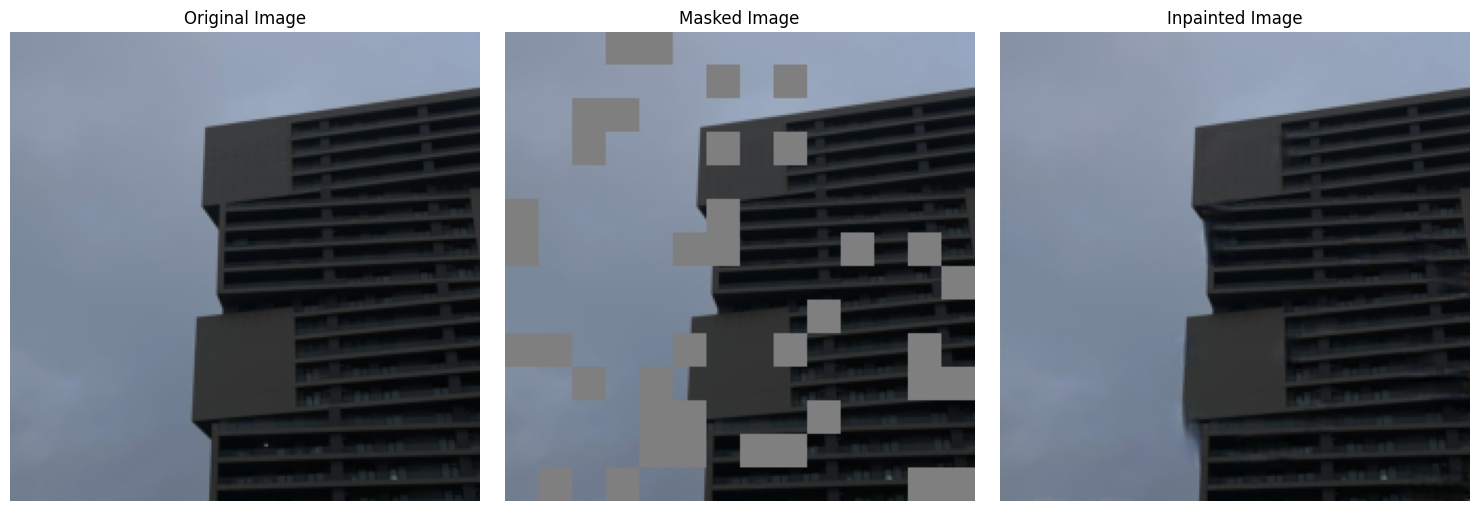

Custom single-folder Dataset evaluation metrics:
test_loss: 0.0737
test_PSNR: 25.0808
test_accuracy: 15.4662
test_MSE: 0.0045


In [58]:
criterion = CombinedLoss().to(device)

def evaluate(model, dataloader, criterion, device="cuda"):
    model.eval()
    test_loss = 0.0
    test_accuracy = 0.0
    test_PSNR = 0.0
    test_MSE = 0.0

    i = 0
    with torch.no_grad():
        for images, masked_images, masks in dataloader:
            images, masked_images, masks = images.to(device), masked_images.to(device), masks.to(device)

            expanded_mask = masks.view(masks.size(0), 14, 14)
            expanded_mask = expanded_mask.repeat_interleave(16, dim=1).repeat_interleave(16, dim=2)
            expanded_mask = expanded_mask.unsqueeze(1).float()

            outputs = model(masked_images, masks)
            loss = criterion(outputs, images, expanded_mask)

            # Calculating metrics
            batch_psnr = psnr(outputs, images, expanded_mask)
            batch_accuracy = pixel_accuracy(outputs, images, expanded_mask)
            test_MSE += F.mse_loss(outputs * expanded_mask, images * expanded_mask).item()

            test_loss += loss.item()
            test_PSNR += batch_psnr
            test_accuracy += batch_accuracy

            # Plotting and saving images
            for j in range(len(images)):
                plot_sample_image(
                    images[j],
                    masked_images[j],
                    outputs[j],
                    expanded_mask[j],
                    save_path="UNet_Custom_Collected_Images",
                    image_name=f"Image_{i * len(images) + j}.png"
                )
            i += 1

    total_batches = len(dataloader)
    avg_test_loss = test_loss / total_batches
    avg_test_PSNR = test_PSNR / total_batches
    avg_test_accuracy = test_accuracy / total_batches
    avg_test_MSE = test_MSE / total_batches

    return {
        "test_loss": avg_test_loss,
        "test_PSNR": avg_test_PSNR,
        "test_accuracy": avg_test_accuracy,
        "test_MSE": avg_test_MSE
    }

dl_jpg_dict = evaluate(model, dl_jpg_loader, criterion, device=device)

print("Custom single-folder Dataset evaluation metrics:")
for k, v in dl_jpg_dict.items():
    print(f"{k}: {v:.4f}")

# Adding Headers to CSV file for Metrics

In [60]:
input_file_path = "training_metrics_unet.csv"

headers = [
    "Epoch",
    "Train Loss",
    "Validation Loss",
    "Train PSNR",
    "Validation PSNR",
    "Train Accuracy",
    "Validation Accuracy",
    "Train MSE",
    "Validation MSE"
]


df = pd.read_csv(input_file_path, header=None)
df.columns = headers

output_file_path = "training_metrics_unet_with_headers.csv"
df.to_csv(output_file_path, index=False)

print(f"CSV file with headers saved to {output_file_path}")

CSV file with headers saved to training_metrics_unet_with_headers.csv
